In [1]:
# CSE 158 Assignment 2

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.svm import NuSVR
from sklearn.svm import SVR

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV


## Read Data

In [3]:
data = pd.read_csv('vehicles.csv')
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [4]:
data.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [5]:
data.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [6]:
data.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

(<AxesSubplot:>,
 0        32895
 6995      3169
 7995      3129
 9995      2867
 8995      2837
          ...  
 21298        1
 49217        1
 63195        1
 19709        1
 17873        1
 Name: price, Length: 15655, dtype: int64)

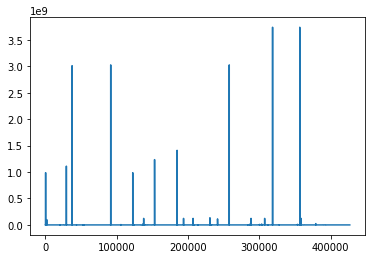

In [7]:
data.price.plot(), data.price.value_counts()

Lots of prices are undisclosed and are set to 0, not very useful for us since this is not the right price for prediction. Will throw off our model if kept in.

In [8]:
data = data[data['price'] > 0]

In [9]:
data.price.value_counts(), data.price.max(), data.price.min()

(6995     3169
 7995     3129
 9995     2867
 8995     2837
 4500     2778
          ... 
 47105       1
 62987       1
 40305       1
 44691       1
 17873       1
 Name: price, Length: 15654, dtype: int64,
 3736928711,
 1)

The max price is way too high, not feasible for a used car to be sold for this much. Same with lower price again, have to change threshold higher.
<br>
Will use greater than $1000 but less than a hundred thousand dollars.

In [10]:
data = data[(data['price'] > 1000) & (data['price'] < 100000)]

In [11]:
data.price.value_counts(), data.price.max(), data.price.min()

(6995     3169
 7995     3129
 9995     2867
 8995     2837
 4500     2778
          ... 
 19239       1
 51662       1
 15425       1
 31548       1
 17873       1
 Name: price, Length: 14613, dtype: int64,
 99999,
 1002)

In [12]:
df = data[['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'size', 'drive', 'type', 'paint_color', 'state']]

Both year and the odometer are correlated with price in a way. The newer the used car the higher the price (hence positive correlation), while the higher the odometer the lower the price (hence negative correlation)

## Prepare Data (Categorical Columns)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378659 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         378659 non-null  int64  
 1   year          377497 non-null  float64
 2   manufacturer  363864 non-null  object 
 3   model         374354 non-null  object 
 4   condition     236126 non-null  object 
 5   cylinders     224127 non-null  object 
 6   fuel          376072 non-null  object 
 7   odometer      376588 non-null  float64
 8   title_status  372108 non-null  object 
 9   transmission  376851 non-null  object 
 10  size          106708 non-null  object 
 11  drive         264247 non-null  object 
 12  type          298163 non-null  object 
 13  paint_color   270641 non-null  object 
 14  state         378659 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 46.2+ MB


In [14]:
df.isna().sum()

price                0
year              1162
manufacturer     14795
model             4305
condition       142533
cylinders       154532
fuel              2587
odometer          2071
title_status      6551
transmission      1808
size            271951
drive           114412
type             80496
paint_color     108018
state                0
dtype: int64

In [15]:
df = df.dropna()


In [16]:
df.size

1099995

In [17]:
## Manufacturer
le = preprocessing.LabelEncoder()
man = df.manufacturer.values
le.fit(man)
df['manufacturer'] = le.transform(man)

In [18]:
## Model
le = preprocessing.LabelEncoder()
model = df.model.values
le.fit(model)
df['model'] = le.transform(model)

In [19]:
## Condition
le = preprocessing.LabelEncoder()
condition = df.condition.values
le.fit(condition)
df['condition'] = le.transform(condition)

In [20]:
## Cylinders 
le = preprocessing.LabelEncoder()
cylinders = df.cylinders.values
le.fit(cylinders)
df['cylinders'] = le.transform(cylinders)

In [21]:
## Fuel
le = preprocessing.LabelEncoder()
fuel = df.fuel.values
le.fit(fuel)
df['fuel'] = le.transform(fuel)

In [22]:
## Title Status
le = preprocessing.LabelEncoder()
title_status = df.title_status.values
le.fit(title_status)
df['title_status'] = le.transform(title_status)

In [23]:
## Transmission
le = preprocessing.LabelEncoder()
transmission = df.transmission.values
le.fit(transmission)
df['transmission'] = le.transform(transmission)

In [24]:
## Size
le = preprocessing.LabelEncoder()
size = df['size'].values
le.fit(size)
df['size'] = le.transform(size)

In [25]:
## Drive
le = preprocessing.LabelEncoder()
drive = df.drive.values
le.fit(drive)
df['drive'] = le.transform(drive)

In [26]:
## Type
le = preprocessing.LabelEncoder()
car_type = df.type.values
le.fit(car_type)
df['type'] = le.transform(car_type)

In [27]:
## Paint Color
le = preprocessing.LabelEncoder()
paint_color = df.paint_color.values
le.fit(paint_color)
df['paint_color'] = le.transform(paint_color)

In [28]:
## State
le = preprocessing.LabelEncoder()
state = df.state.values
le.fit(state)
df['state'] = le.transform(state)

In [29]:
df.corr()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,size,drive,type,paint_color,state
price,1.000000,0.262123,-0.061816,0.067151,0.011955,0.260596,-0.352256,-0.165322,-0.025603,-0.025224,-0.054421,-0.158280,0.090991,0.054775,-0.014029
year,0.262123,1.000000,0.056290,0.056022,-0.032392,-0.201560,-0.020659,-0.112819,0.065571,-0.226571,0.021447,-0.256230,0.019146,0.032609,0.018388
manufacturer,-0.061816,0.056290,1.000000,-0.019677,-0.024864,-0.250465,0.033381,0.006220,0.023919,0.053333,0.020032,-0.077651,-0.019153,-0.018286,-0.022830
model,0.067151,0.056022,-0.019677,1.000000,-0.004255,0.094616,0.022987,-0.005418,-0.021647,-0.017905,0.010170,-0.125589,-0.119282,0.011259,0.023986
condition,0.011955,-0.032392,-0.024864,-0.004255,1.000000,0.024494,-0.013012,0.007170,0.029724,0.017852,-0.019448,0.037573,0.031729,0.012717,0.018496
cylinders,0.260596,-0.201560,-0.250465,0.094616,0.024494,1.000000,-0.202035,0.045795,-0.065659,-0.085551,-0.047075,-0.026250,0.053520,0.030336,0.011884
fuel,-0.352256,-0.020659,0.033381,0.022987,-0.013012,-0.202035,1.000000,-0.024453,0.017198,-0.006983,0.068187,0.104659,-0.189522,-0.072574,-0.017572
odometer,-0.165322,-0.112819,0.006220,-0.005418,0.007170,0.045795,-0.024453,1.000000,-0.033269,0.019126,-0.001629,-0.006894,0.000290,0.004923,-0.003280
title_status,-0.025603,0.065571,0.023919,-0.021647,0.029724,-0.065659,0.017198,-0.033269,1.000000,-0.001875,-0.003195,-0.008651,0.004390,-0.025556,0.003702
transmission,-0.025224,-0.226571,0.053333,-0.017905,0.017852,-0.085551,-0.006983,0.019126,-0.001875,1.000000,-0.051754,0.095553,-0.021812,-0.024172,-0.004808


## Model Selection

Prepare data.

In [30]:
obs = df.price
x = df.drop(columns=['price'])
Xtrain, Xtest, ytrain, ytest = train_test_split(x, obs, test_size = 0.25)

## Model Selection - Linear Regression

In [31]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
preds = lr.predict(Xtest)
r2_score(ytest, preds)

0.2786151309819396

Pretty bad R^2.

## Model Selection - Lasso Regression

In [32]:
lasso = Lasso()
lasso.fit(Xtrain, ytrain)
preds = lasso.predict(Xtest)
r2_score(preds, ytest)

-1.4359278637902348

## Model Selection - Ridge Regression

In [33]:
ridge = Ridge()
ridge.fit(Xtrain, ytrain)
preds = ridge.predict(Xtest)
r2_score(preds, ytest)

-1.4344414419088278

## Model Selection - Decision Tree Regressor

In [34]:
dtr = DecisionTreeRegressor()
dtr.fit(Xtrain, ytrain)
preds = dtr.predict(Xtest)
r2_score(preds, ytest)

0.7594899176217513

Better R^2

## Model Selection - Linear SVR

In [35]:
lsvr = LinearSVR()
lsvr.fit(Xtrain, ytrain)
preds = lsvr.predict(Xtest)
r2_score(preds, ytest)

/usr/local/bin/kerasenv/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


-3.86192674563718

## Model Selection - Nu SVR

In [36]:
nsvr = NuSVR()
nsvr.fit(Xtrain, ytrain)
preds = nsvr.predict(Xtest)
r2_score(preds, ytest)

-70.58529409958962

## Model Selection - SVR

In [37]:
svr = SVR()
svr.fit(Xtrain, ytrain)
preds = svr.predict(Xtest)
r2_score(preds, ytest)

-44.64204543701798

## Model Selection - Ada Boost Regressor

In [38]:
adab = AdaBoostRegressor()
adab.fit(Xtrain, ytrain)
preds = adab.predict(Xtest)
r2_score(preds, ytest)

-0.048153105754245695

## Model Selection - Gradient Boosting Regressor

In [39]:
gbr = GradientBoostingRegressor()
gbr.fit(Xtrain, ytrain)
preds = gbr.predict(Xtest)
r2_score(preds, ytest)

0.7134240228056221

## Model Selection - Random Forest Regressor

In [40]:
rfr = RandomForestRegressor()
rfr.fit(Xtrain, ytrain)
preds = rfr.predict(Xtest)
r2_score(preds, ytest)

0.8547950305187971

## Model Selection - Extra Trees Regressor

In [41]:
etr = ExtraTreesRegressor()
etr.fit(Xtrain, ytrain)
preds = etr.predict(Xtest)
r2_score(preds, ytest)

0.8635851923309298

Better R^2

## Model Selection - XGBoost Regressor

In [42]:
xgbm = XGBRegressor()
xgbm.fit(Xtrain, ytrain)
preds = xgbm.predict(Xtest)
r2_score(preds, ytest)

## Model Selection - LGBM Regressor

In [43]:
lbgm = LGBMRegressor()
lbgm.fit(Xtrain, ytrain)
preds = lbgm.predict(Xtest)
r2_score(preds, ytest)

## Cross Validation on Highest Performing Models

## Cross Validation on Random Forest Generator

In [69]:
rfr=RandomForestRegressor()
k_fold_cv = 5
params = {
 "n_estimators" : [500, 1000, 1500],
 "max_features" : ["auto", "log2", "sqrt"],
 "min_samples_leaf" : [1, 50, 100, 200],
 "bootstrap": [True, False]
}

random = RandomizedSearchCV(rfr, param_distributions=params, cv=k_fold_cv,
 n_iter = 5, scoring='neg_mean_absolute_error', n_jobs=-1,
 return_train_score=True)
random.fit(Xtrain, ytrain)
print('Best hyper parameter:', random.best_params_)


Best hyper parameter: {'n_estimators': 1500, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}


In [70]:
preds = random.predict(Xtest)
r2_score(ytest, preds)

0.8608358254945203

## Cross Validation on Extra Trees Regressor

In [71]:
etr=ExtraTreesRegressor()
k_fold_cv = 5
params = {
 "n_estimators" : [100, 500, 1000, 1500],
 "max_features" : [None, "log2", "sqrt"],
 "min_samples_leaf" : [1, 50, 100, 200],
 "bootstrap": [True, False]
}

random = RandomizedSearchCV(etr, param_distributions=params, cv=k_fold_cv,
 n_iter = 5, scoring='neg_mean_absolute_error', n_jobs=-1,
 return_train_score=True)
random.fit(Xtrain, ytrain)
print('Best hyper parameter:', random.best_params_)


Best hyper parameter: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}


In [72]:
preds = random.predict(Xtest)
r2_score(ytest, preds)

0.8602015606364788